In [15]:
import skimage as ski
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, sys
from tqdm import tqdm
import re
import scipy.stats as stats
from skimage.transform import rescale, resize
import torch
# Disable jedi autocompleter
%config Completer.use_jedi = False
%matplotlib inline

os.chdir("/export/raid1/home/ojeda040/Second-Sight")

In [25]:
def image_zscore(x):
    mn = np.mean(x)
    stdev = np.std(x)
    x -= mn
    x /= stdev
    return x

def make_grating(side, wavelength, angle, zscore = True):
    min_x = -np.floor(side/2.)
    max_x = -min_x + 1
    x = np.arange(min_x, max_x, 1)
    X, Y = np.meshgrid(x, x)
    grating = np.sin(
        2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength
    )
    if zscore:
        grating = image_zscore(grating)
    return grating

def fft2dpower(image):
    ft = np.fft.ifftshift(image)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    return np.abs(ft)**2

def fft2daverage(ft2d, norm = True):
    
    npix = ft2d.shape[0]
    ##cycles per image
    kfreq = np.fft.fftshift(np.fft.fftfreq(npix)) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    ft2d = ft2d.flatten()

    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, ft2d,
                                         statistic = "mean",
                                         bins = kbins)
    if norm:
        Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

def image_indices(folder, subject = 1):
        
    # Directory path
    dir_path = "/export/raid1/home/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/"
    
    # Grab the list of files
    files = []
    for path in os.listdir(dir_path):
        
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            files.append(path)
    
    # Get just the image number and then sort the list. 
    indicies = []
    for i in range(len(files)):
        indicies.append(int(re.search(r'\d+', files[i]).group()))
    
    indicies.sort()
    
    return indicies

def grab_images(experiment_name, subject = 1):
    
    # Directory path
    directory_path = "/export/raid1/home/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + experiment_name + "/"
    
    folders = ["iter_0", "iter_3", "iter_5"]
    
    ground_truth    = []
    early_visual    = []
    higher_visual   = []
    nsd_general     = []
    
    # List of image numbers created. 
    idx = image_indices(experiment_name, subject = subject)
    idx = [20]
    
    # Append rows to an empty DataFrame
    for i in tqdm(idx, desc="gathering images"):
        
        ground_truth_path = directory_path + str(i) + "/Ground Truth.png"
        ground_truth_image = np.array(Image.open(ground_truth_path).convert('L'))
        ground_truth.append(ground_truth_image)
        
        # Iterate through all the folders
        for folder in folders:
            
            # Create the path
            path = directory_path + str(i) + "/" + folder
            
            batch_number = torch.load(path + "/best_batch_index.pt")
            print(batch_number)
            
            # Iterate over every file
            for filename in os.listdir(path + "/batch_" + str(int(batch_number))): 
                
                if(".pt" in filename):
                    continue
                
                if("0" in folder):
                    # Reconstruction image
                    reconstruction_path = path + '/batch_' + str(int(batch_number)) + '/' + filename
                    reconstruction = np.array(Image.open(reconstruction_path).convert('L'))
                    higher_visual.append(reconstruction)
                    
                if("3" in folder):
                    # Reconstruction image
                    reconstruction_path = path + '/batch_' + str(int(batch_number)) + '/' + filename
                    reconstruction = np.array(Image.open(reconstruction_path).convert('L'))
                    nsd_general.append(reconstruction)
                    
                if("5" in folder):
                    # Reconstruction image
                    reconstruction_path = path + '/batch_' + str(int(batch_number)) + '/' + filename
                    reconstruction = np.array(Image.open(reconstruction_path).convert('L'))
                    early_visual.append(reconstruction)
                    
    return ground_truth, early_visual, higher_visual, nsd_general
                        
    

  
    

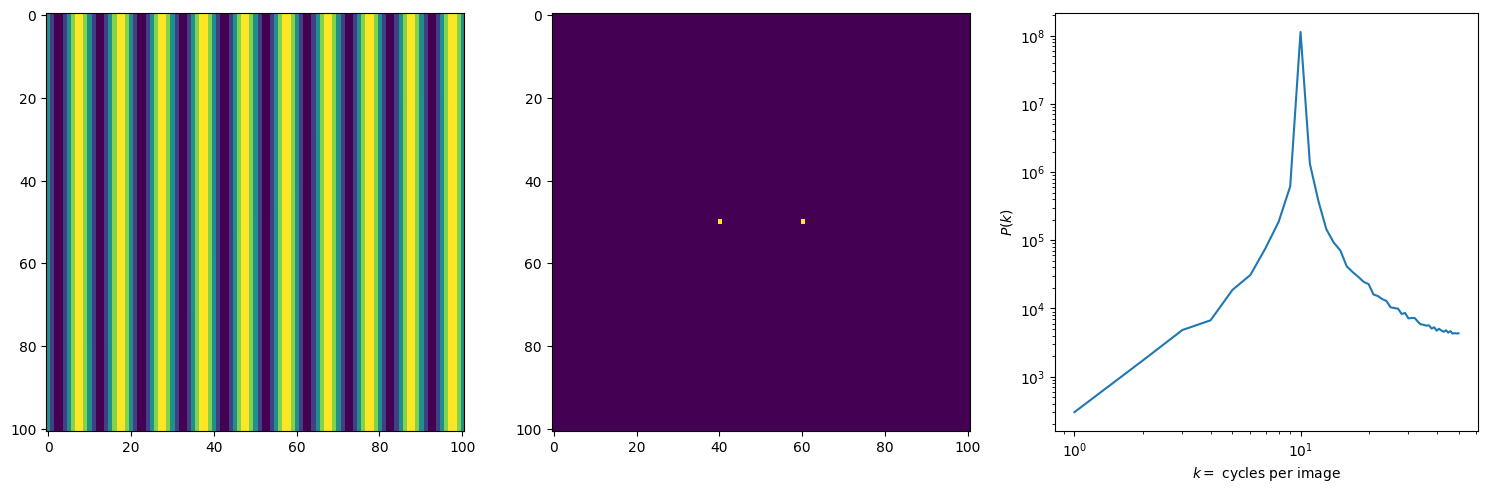

In [5]:
wavelength = 10
angle = np.pi / 1.
grating = make_grating(100, wavelength, angle)
gps = fft2dpower(grating)
freq,amp = fft2daverage(gps)

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(grating)
plt.subplot(1,3,2)
plt.imshow(gps)
plt.subplot(1,3,3)
plt.loglog(freq, amp)
plt.xlabel("$k=$ cycles per image")
plt.ylabel("$P(k)$")
plt.tight_layout()


(512, 512)


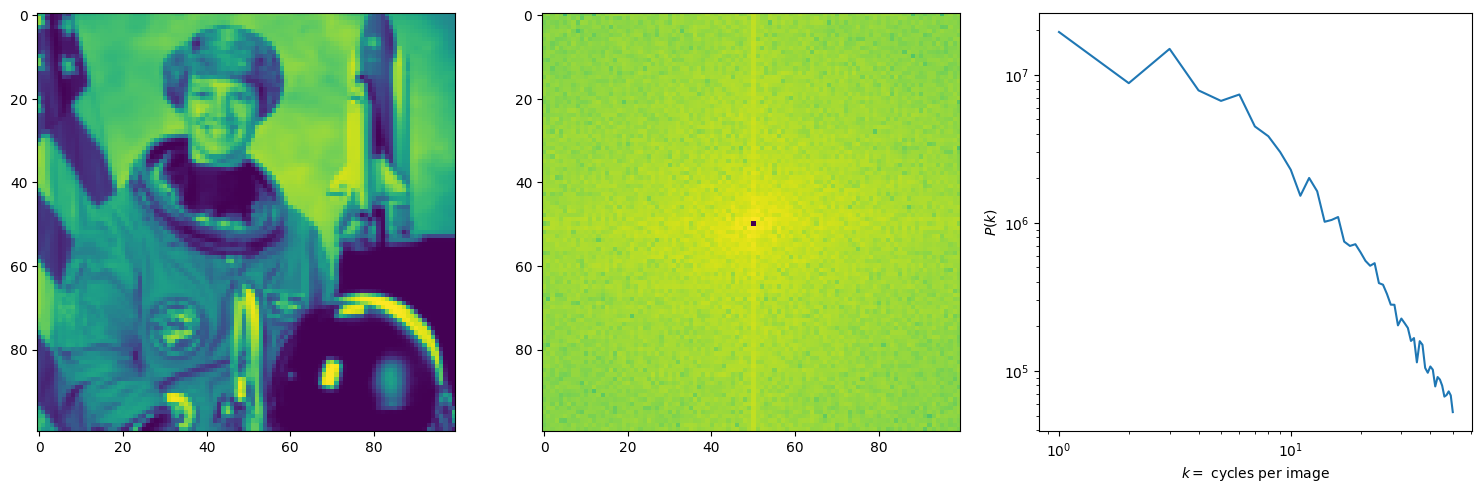

In [9]:
test_img = ski.data.astronaut
x = test_img()
x = ski.color.rgb2gray(x)
x  = resize(x,(100,100))
x = image_zscore(x)

xps = fft2dpower(x)
freq,amp = fft2daverage(xps)
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(x)
plt.subplot(1,3,2)
plt.imshow(np.log(xps))
plt.subplot(1,3,3)
plt.loglog(freq, amp)
plt.xlabel("$k=$ cycles per image")
plt.ylabel("$P(k)$")
plt.tight_layout()

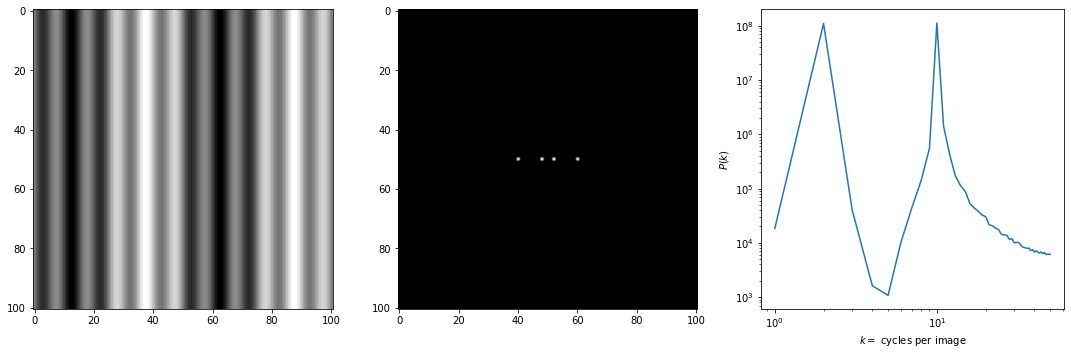

In [153]:
side = 100
w1 = 10
w2 = 50
angle = np.pi / 1.
grating_1 = make_grating(side, w1,angle, zscore=True)
grating_2 = make_grating(side, w2,angle, zscore=True)
reference_image = grating_1 + grating_2
rps = fft2dpower(reference_image)
freq,amp = fft2daverage(rps)
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(reference_image)
plt.subplot(1,3,2)
plt.imshow(rps)
plt.subplot(1,3,3)
plt.loglog(freq, amp)
plt.xlabel("$k=$ cycles per image")
plt.ylabel("$P(k)$")
plt.tight_layout()

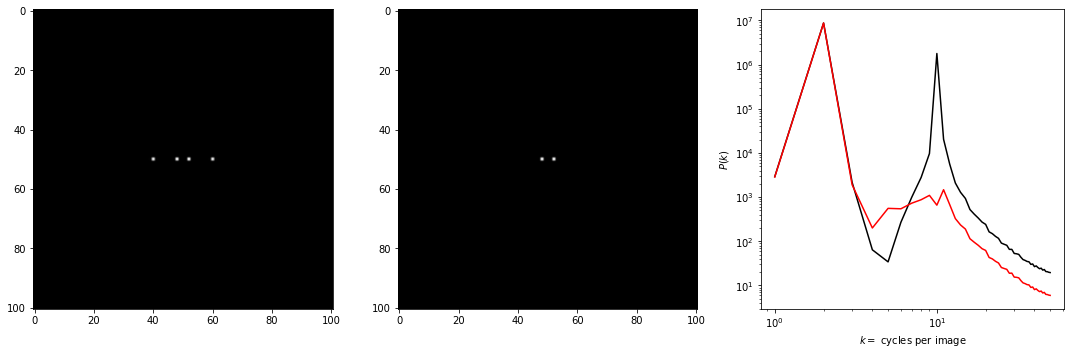

In [191]:
g1ft = fft2dpower(grating_1)
weird_rescaling_factor = .991
g1ft *= weird_rescaling_factor
diff_ft = np.abs(rps-g1ft)
freq,diff_amp = fft2daverage(diff_ft, norm=False)
rps = fft2dpower(reference_image)
freq,amp = fft2daverage(rps,norm = False)
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(rps)
plt.subplot(1,3,2)
plt.imshow(diff_ft)
plt.subplot(1,3,3)
plt.loglog(freq, amp, 'k')
plt.loglog(freq, diff_amp, 'r')
plt.xlabel("$k=$ cycles per image")
plt.ylabel("$P(k)$")
plt.tight_layout()

In [27]:
ground_truth, early_visual, higher_visual, nsd_general = grab_images("Final Run: SCS UC LD 6:100:4 Dual Guided clip_iter", subject = 1)

# print(ground_truth[0].shape)

# print(early_visual[0].shape)

# print(len(higher_visual))

# print(len(nsd_general))



gathering images:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1)
tensor(0)
tensor(3)


gathering images: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

(768, 768)
(768, 768)
22
20
